In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

data= fetch_openml('mnist_784', version=1)#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"])

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(dfData[data["feature_names"]], dfData["target"]):
    X_train = dfData[data["feature_names"]].iloc[train_index]
    X_test = dfData[data["feature_names"]].iloc[test_index]

    y_train = dfData["target"].iloc[train_index]
    y_test = dfData["target"].iloc[test_index]

In [3]:
from sklearn.ensemble import VotingClassifier

ests = []
for i in range(10): #loop makes it easier for the input shape, estimators must be in a tuple
    ests.append((f'dec_tree_{i}',DecisionTreeClassifier(max_depth=3,
                                                      max_features='sqrt',
                                                      splitter='random'))) #"random": faster training than "best"
vote_clf = VotingClassifier(estimators=ests,
                          voting='hard', # soft
                          weights=None, # weights for each classifier as a list
                                        # a good way to get weights is to base them off of relative performance
                                        # in previous CV runs
                          n_jobs=2,
                          flatten_transform=True # only relevant for soft voting, affects output shape
                          )

vote_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('dec_tree_0',
                              DecisionTreeClassifier(max_depth=3,
                                                     max_features='sqrt',
                                                     splitter='random')),
                             ('dec_tree_1',
                              DecisionTreeClassifier(max_depth=3,
                                                     max_features='sqrt',
                                                     splitter='random')),
                             ('dec_tree_2',
                              DecisionTreeClassifier(max_depth=3,
                                                     max_features='sqrt',
                                                     splitter='random')),
                             ('dec_tree_3',
                              DecisionTreeClassifier(max_depth=3,
                                                     max_f...
                              DecisionTreeClassifier(max_depth=3,
                                                     max_features='sqrt',
                                                     splitter='random')),
                             ('dec_tree_7',
                              DecisionTreeClassifier(max_depth=3,
                                                     max_features='sqrt',
                                                     splitter='random')),
                             ('dec_tree_8',
                              DecisionTreeClassifier(max_depth=3,
                                                     max_features='sqrt',
                                                     splitter='random')),
                             ('dec_tree_9',
                              DecisionTreeClassifier(max_depth=3,
                                                     max_features='sqrt',
                                                     splitter='random'))],
                 n_jobs=2)

In [4]:
for estimator,est_name in zip(vote_clf.estimators_,vote_clf.named_estimators_): #estimators_: gives us each individual trained version
    print(f'{est_name}:',round(estimator.score(X_test,y_test.astype(int)),3))
print('Voting classifier:',round(vote_clf.score(X_test,y_test),3))

#result: performance is bigger than the individual values
#we minimize the errors because the errors are random (this boosts our performance)

dec_tree_0: 0.38
dec_tree_1: 0.388
dec_tree_2: 0.368
dec_tree_3: 0.395
dec_tree_4: 0.38
dec_tree_5: 0.34
dec_tree_6: 0.35
dec_tree_7: 0.403
dec_tree_8: 0.308
dec_tree_9: 0.392
Voting classifier: 0.527


In [5]:
vote_clf_soft = VotingClassifier(estimators=[
                                        ('log_reg',LogisticRegression()),
                                        ('dec_tree',DecisionTreeClassifier(max_depth=3)),
                                        ('GaussianNB',GaussianNB())
                                        ],
                          voting='soft', # soft
                          weights=None, # weights for each classifier as a list
                          n_jobs=2,
                          flatten_transform=True # only relevant for soft voting
                          )

vote_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('dec_tree', DecisionTreeClassifier(max_depth=3)),
                             ('GaussianNB', GaussianNB())],
                 n_jobs=2, voting='soft')

In [6]:
for estimator,est_name in zip(vote_clf_soft.estimators_,vote_clf_soft.named_estimators_):
    print(f'{est_name}:',round(estimator.score(X_test,y_test.astype(int)),3))
print('Soft voting classifier:',round(vote_clf_soft.score(X_test,y_test),3))

#in this case: voting classifier is worse than the individual components
#log reg performs better than log reg with 2 other classifiers
#NOTE: using an ensemble won't guarantee a better performance!!!

log_reg: 0.924
dec_tree: 0.494
GaussianNB: 0.55
Soft voting classifier: 0.77


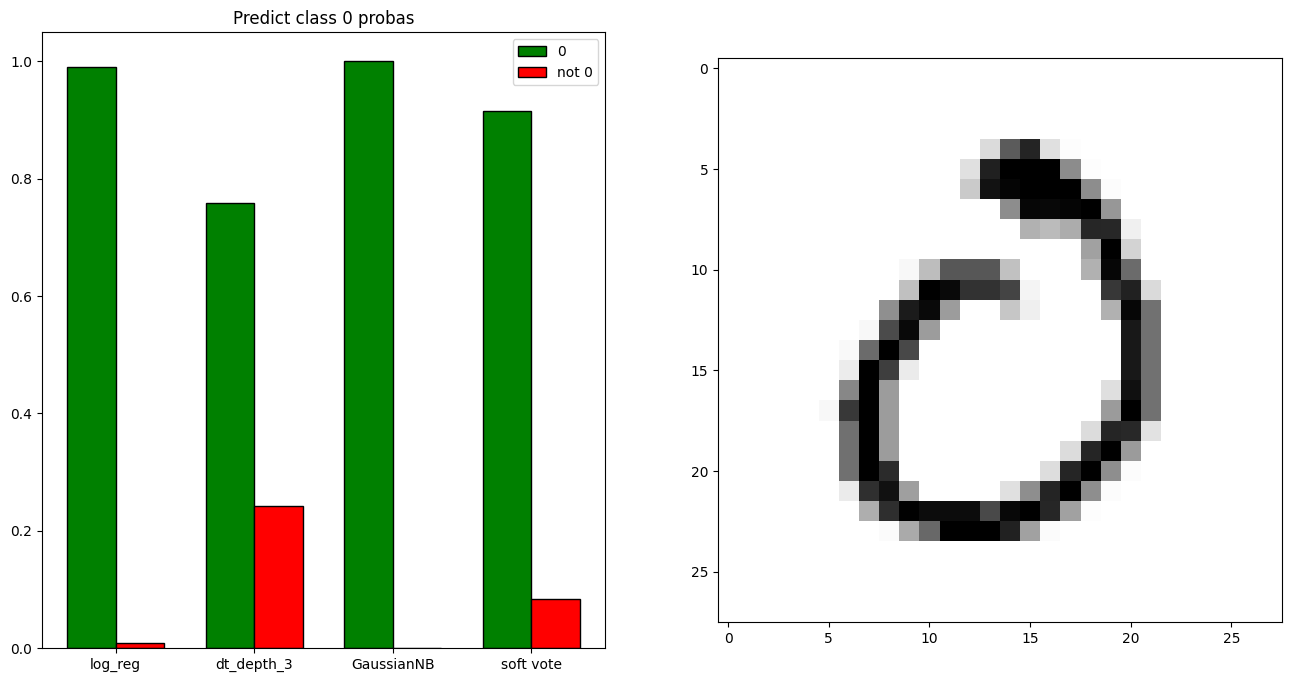

In [7]:
#this code finds us the individual probabilities either having a class A or not class A

ind = 1

probas = []
for estimator,est_name in zip(vote_clf_soft.estimators_,vote_clf_soft.named_estimators_):
    probas.append(estimator.predict_proba(X_test[ind:ind+1]))

probas.append(vote_clf_soft.predict_proba(X_test[ind:ind+1]))

pred_class = int(y_test.values[ind])
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
i = 0
w = 0.35
for prob in probas:
    predNot = 0
    predIs = 0

    #loop checks if it's the probability or not
    for k in range(len(prob[0])):
        if k == pred_class:
            predIs += prob[0, k]
        else:
            predNot += prob[0, k]
    if i == 0:
        bars = plt.bar([i-w/2,i+w/2],height=[predIs,predNot],color=["green","red"],width=w,edgecolor='black')
    else:
        plt.bar([i-w/2,i+w/2],height=[predIs,predNot],color=["green","red"],width=w,edgecolor='black')

    i +=1

plt.xticks(range(len(probas)),['log_reg','dt_depth_3',
                               'GaussianNB',
                               'soft vote'])
plt.title(f"Predict class {pred_class} probas")
plt.legend([bars[0], bars[1]], [f'{pred_class}', f'not {pred_class}'])
ax = fig.add_subplot(122)
plt.imshow(X_test.iloc[ind].astype(int).values.reshape(28,-1),cmap=plt.get_cmap('gray_r'))
plt.show()

#result decision overview if it's a 0 or not a 0

In [8]:
probas

#result: showing the percentage of being a class 0 (the number 0)

[array([[9.90393632e-01, 2.83853348e-09, 3.94174003e-05, 2.88725718e-03,
         3.60185907e-07, 2.99898286e-03, 1.46497429e-05, 1.35144363e-07,
         3.51101914e-03, 1.54543777e-04]]),
 array([[0.75851774, 0.00175623, 0.07850369, 0.02651914, 0.00579557,
         0.0770987 , 0.0337197 , 0.00245873, 0.01176677, 0.00386372]]),
 array([[1.00000000e+000, 0.00000000e+000, 1.34593949e-265,
         5.19212386e-150, 3.08910853e-295, 2.27539763e-164,
         8.42114015e-133, 0.00000000e+000, 8.97475908e-069,
         5.08127717e-301]]),
 array([[9.16303790e-01, 5.85412490e-04, 2.61810352e-02, 9.80213338e-03,
         1.93197816e-03, 2.66992277e-02, 1.12447849e-02, 8.19621210e-04,
         5.09259706e-03, 1.33941999e-03]])]